In [1]:
import uproot
import coffea.hist as hist
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep

hep.set_style("CMS")

In [2]:
v0_file = "/work/gallim/root_files/vertex_investigation/0th_vertex/output_GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8_storeWeights_alesauva-UL2018_0-10_6_4-v0-RunIISummer19UL18MiniAOD-106X_upgrade2018_realistic_v11_L1v1-v1-3f96409841a3cc85b911eb441562baae_USER_*.root"
v_custom_file = "/work/gallim/root_files/vertex_investigation/our_vertex/output_GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8_storeWeights_alesauva-UL2018_0-10_6_4-v0-RunIISummer19UL18MiniAOD-106X_upgrade2018_realistic_v11_L1v1-v1-3f96409841a3cc85b911eb441562baae_USER_*.root"

tree_name = "diphotonDumper/trees/ggH_125_13TeV_All_$SYST"

#variables = ['candidate_id', 'weight', 'mass', 'pt', 'eta', 'leadPt', 'subleadPt', 'rho', 'nvtx', 'event', 'lumi', 'processIndex', 'run', 'npu', 'puweight']

specs = {
    'mass': {
        'bins': 80,
        'range': [100, 140]
    },
    'pt': {
        'bins': 80,
        'range': [0, 300]
    },
    'eta': {
        'bins': 80,
        'range': [-5, 5]
    },
    'leadPt': {
        'bins': 80,
        'range': [0, 300]
    },
    'subleadPt': {
        'bins': 80,
        'range': [0, 200]  
    },
    'rho': {
        'bins': 80,
        'range': [0, 50]
    }
}
variables = list(specs.keys())

In [3]:
histos = {}

for var, sp in specs.items():
    histos[var] = hist.Hist("Counts", 
                            hist.Cat("vertex", "Vertex"),
                            hist.Bin(var, "${}$".format(var), sp["bins"], *sp["range"])
                           )

In [5]:
%%time

for var, histo in histos.items():
    for batch in uproot.iterate(["{}:{}".format(v_custom_file, tree_name)], expressions=[var, "weight"], library="np"):
        histo.fill(vertex="Vertex Reco", **batch)
    for batch in uproot.iterate(["{}:{}".format(v0_file, tree_name)], expressions=[var, "weight"], library="np"):
        histo.fill(vertex="Vertex 0th", **batch)

CPU times: user 16.2 s, sys: 140 ms, total: 16.4 s
Wall time: 16.5 s


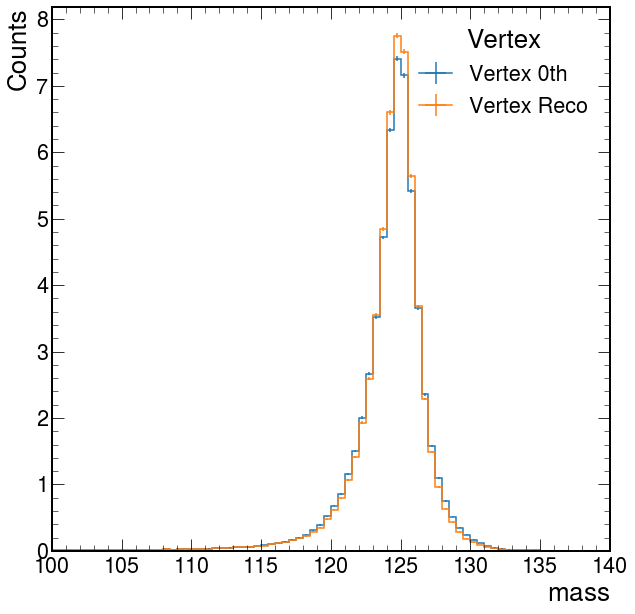

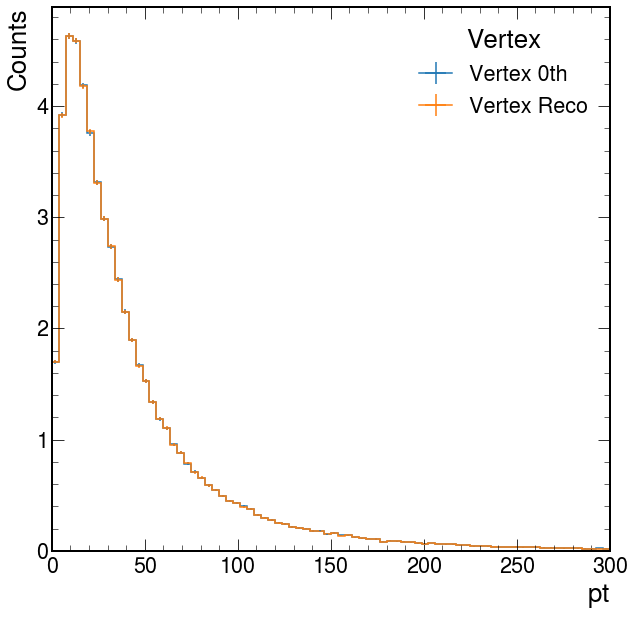

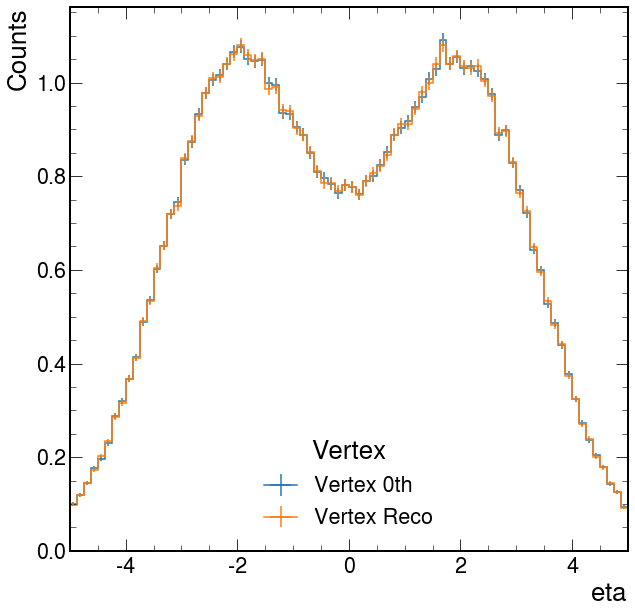

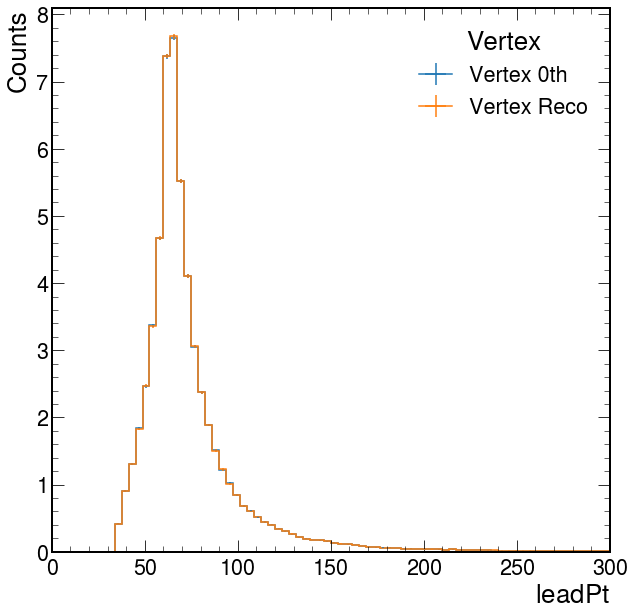

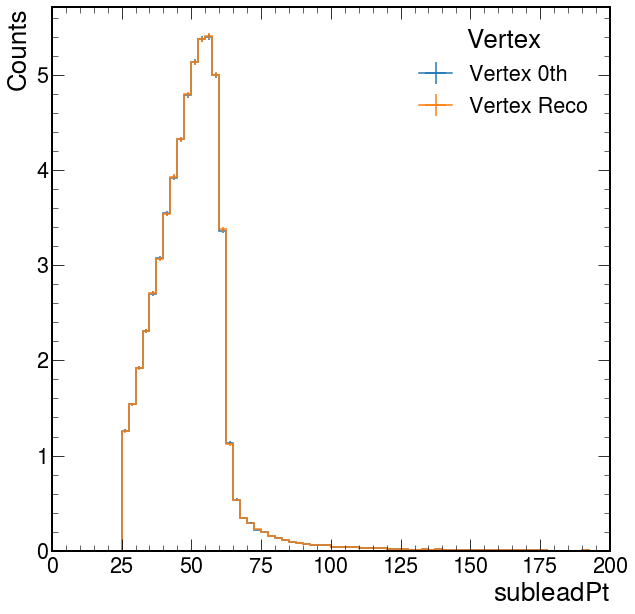

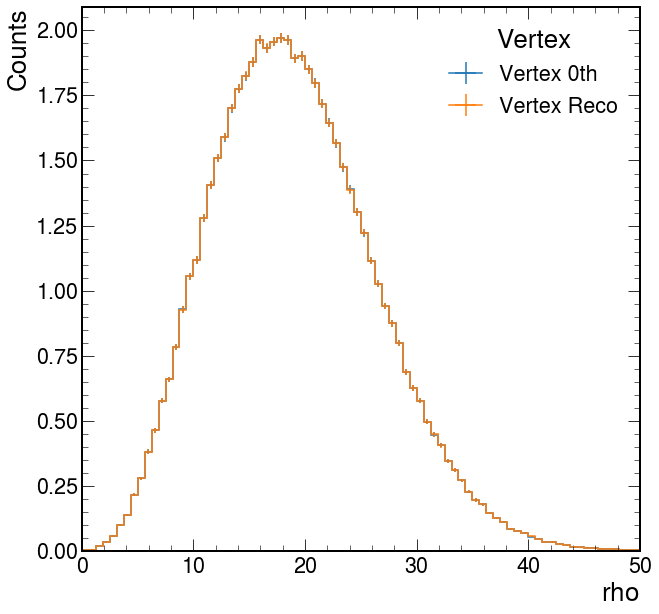

In [6]:
for histo in histos.values():
    fig, ax = plt.subplots()
    hist.plot1d(histo)
    plt.show();